In [2]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [3]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [4]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]

Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200183383
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071047842222)]
Initial energy: -6.123105625617642
Optimizing energy with indices [244, 74, 210, 225]...
Starting point: [np.float64(0.785398163396527), np.float64(-0.7853981633984565), np.float64(0.12248927944983938), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.2041705292020639)
Current ansatz: [244, 74, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531856
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.0894929267348785)]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 74, 210, 225, 156]...
Starting point: [np.float64(0.7853981633982173), np.float64(-0.7853981633972483), np.float64(0.1635701974083824), np.float64(-0.16356963668287802), np.float64(0.0)]

Current energy: -6.46410161513538
(change of -0.13682546031567444)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.46410161460898
(change of -0.13682545978899796)
Current ansatz: [241, 79, 228, 210, 108]
Performing final convergence check...
Total gradient norm: 0.00032540987752766417

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.00000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-1.9999999999664215)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 210]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.12310562560079
(change of -0.12310562567127192)
Current ansatz: [228, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917529967152875
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850731472484284)]
Initial energy: -6.12310562560079
Optimizing energy with indices [228, 79, 210, 225]...
Starting point: [np.float64(-0.7853960818962284), np.float64(0.7853979330782069), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926737891)]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 198]...
Starting point: [np.float64(0.7853981700346647), np.float64(0.7853981900506334), np.float64(-0.1635701974085294), np.float64(0.16356963668219085), np.float64(0.0)]

Current energy: -6.464101614835283
(change of -0.13682546001557316)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.000000000000006)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 210]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071047541058)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 225]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.99999999999442)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 228]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.12310562561065
(change of -0.12310562561246563)
Current ansatz: [228, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752214895575
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.485068789862022)]
Initial energy: -6.12310562561065
Optimizing energy with indices [228, 74, 228, 108]...
Starting point: [np.float64(-0.7853983869831829), np.float64(-0.7853991695302484), np.float64(0.12248869758310722), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615481486
(change of -0.20417052920420975)
Current ansatz: [228, 74, 228, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962434904306
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089493170038843)]
Initial energy: -6.32727615481486
Optimizing energy with indices [228, 74, 228, 108, 120]...
Starting point: [np.float64(-0.7853982969609276), np.float64(-0.7853991637531007), np.float64(0.16357021035137015), np.float64(-0.16356958141878564), np.float64(0.0)]

Current energy: -6.464101615092039
(change of -0.136825460277179)
Current ansatz: [228, 74, 228, 108, 120]
Performing final convergence check...
Total gradient norm: 9.118305257351268e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962434904306 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916426871504)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 147]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072783
(change of -0.13682546025279674)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625610651
(change of -0.12310562561245941)
Current ansatz: [225, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955753
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850687898689525)]
Initial energy: -6.123105625610651
Optimizing energy with indices [225, 26, 225, 147]...
Starting point: [np.float64(0.7853983869831791), np.float64(0.7853991695302315), np.float64(-0.12248869758310756), np.float64(0.0)]

Current energy: -6.327276154816633
(change of -0.20417052920598167)
Current ansatz: [225, 26, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096405641353
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916407332023)]
Initial energy: -6.327276154816633
Optimizing energy with indices [225, 26, 225, 147, 210]...
Starting point: [np.float64(0.78539843791816

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000006)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 216]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.1231056256176366)
Current ansatz: [244, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200769645
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168968)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 228]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562482
(change of -0.1231056256329639)
Current ansatz: [228, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710484682805)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 198]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999999999996)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 225]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [241, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 147]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819989
(change of -0.2041705292023419)
Current ansatz: [241, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 180]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562496
(change of -0.12310562563297811)
Current ansatz: [228, 79, 180]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775836
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682867)]
Initial energy: -6.123105625562496
Optimizing energy with indices [228, 79, 180, 210]...
Starting point: [np.float64(-0.7853947065772664), np.float64(0.7853985308794444), np.float64(-0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491643867186)]
Initial energy: -6.327276154819957
Optimizing energy with indices [244, 74, 225, 198, 210]...
Starting point: [np.float64(0.7853981633827103), np.float64(-0.7853981633905597), np.float64(-0.1635702864850013), np.float64(-0.16356997194328274), np.float64(0.0)]

Current energy: -6.464101615072805
(change of -0.13682546025284736)
Current 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001350654121170328

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041795563 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764282)
Current ansatz: [241, 74, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327167
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710484797043)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 74, 210, 201]...
Starting point: [np.float64(-0.7853981648267379), np.float64(-0.7853981619178165), np.float64(0.12248927961411439), np.float64(0.0)]

Current energy: -6.327276154819973
(change of -0.20417052920232592)
Current ansatz: [241, 74, 210, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042410149
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894916429638877)]
Initial energy: -6.327276154819973
Optimizing energy with indices [241, 74, 210, 201, 225]...
Starting point: [np.float64(-0.78539816442

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.48507104742887)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 198]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.327276154819711
(change of -0.2041705292020728)
Current ansatz: [241, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053179
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.08949292673488)]
Initial energy: -6.327276154819711
Optimizing energy with indices [241, 26, 228, 198, 210]...
Starting point: [np.float64(-0.7853981638730614), np.float64(0.7853981637530902), np.float64(0.1635701974083659), np.float64(-0.16356963668287355), np.float64(0.0)]

Current energy: -6.464101615135378
(change of -0.13682546031566645)
Current ansatz:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955728
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868942)]
Initial energy: -6.123105625610642
Optimizing energy with indices [228, 74, 225, 210]...
Starting point: [np.float64(-0.7853983869831797), np.float64(-0.7853991695302367), np.float64(-0.12248869758310571), np.float64(0.0)]

Current energy: -6.327276154816355
(change of -0.20417052920571255)
Current ansatz: [228, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096256714494
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089492948563267)]
Initial energy: -6.327276154816355
Optimizing energy with indices [228, 74, 225, 210, 147]...
Starting point: [np.float64(-0.785398438893094), np.float64(-0.7853991591701955), np.float64(-0.1635701984907769), np.float64(0.1635696317030657), np.float64(0.0)]

Current energy: -6.464101615132119
(change of -0.13682546031576415)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916438682527)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 147]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614554787
(change of -0.13682545973480487)
Current ansatz: [241, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 225]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610644
(change of -0.12310562561245586)
Current ansatz: [225, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955813
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868988)]
Initial energy: -6.123105625610644
Optimizing energy with indices [225, 79, 225, 210]...
Starting point: [np.float64(0.7853983869831812), np.float64(0.7853991695302517), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288698)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 147]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.327276154819711
(change of -0.2041705292020728)
Current ansatz: [241, 26, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531794
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.0894929267348794)]
Initial energy: -6.327276154819711
Optimizing energy with indices [241, 26, 228, 147, 120]...
Starting point: [np.float64(-0.7853981638732243), np.float64(0.7853981637530733), np.float64(0.16357019740836667), np.float64(-0.16356963668287391), np.float64(0.0)]

Current energy: -6.464101615135322
(change of -0.1368254603156105)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710475410684)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 201]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.12248927937223411), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154820032
(change of -0.204170529202381)
Current ansatz: [244, 79, 210, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963744097293
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894919049611254)]
Initial energy: -6.327276154820032
Optimizing energy with indices [244, 79, 210, 201, 225]...
Starting point: [np.float64(0.7853982036078874), np.float64(0.7853982533205262), np.float64(0.16357026836397243), np.float64(0.1635699037121557), np.float64(0.0)]

Current energy: -6.464101614752833
(change of -0.13682545993280115)
Current ansatz: [244, 79, 210, 201, 225]
Performing final convergence check...
Total gradient norm: 0.00023661535824530413

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963744097293 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417229
(change of -1.3737154597822618)
Current ansatz: [211, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181085
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999998057472)]
Initial energy: -5.999999999417229
Optimizing energy with indices [211, 244, 79, 225]...
Starting point: [np.float64(-9.855379305101342e-06), np.float64(0.7853981714334987), np.float64(0.7853981407341446), np.float64(0.0)]

Current energy: -6.123105625047579
(change of -0.12310562563034999)
Current ansatz: [211, 244, 79, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620051138
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710482521707)]
Initial energy: -6.123105625047579
Optimizing energy with indices [211, 244, 79, 225, 210]...
Starting point: [np.float64(-9.641919911162

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float64(0.0)]

Current energy: -6.000000000000004
(change of -1.7639320225002084)
Current ansatz: [241, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132728
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.000000000000003)]
Initial 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819991
(change of -0.2041705292023437)
Current ansatz: [241, 74, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042909304
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.089491642525509)]
Initial energy: -6.327276154819991
Optimizing energy with indices [241, 74, 201, 228, 141]...
Starting point: [np.float64(-0.7853981659216249), np.float64(-0.7853981650153637), np.float64(0.16357028657819198), np.float64(0.16356997229392323), np.float64(0.0)]

Current energy: -6.4641016150726
(change of -0.13682546025260933)
Current ansatz: [241, 74, 201, 228, 141]
Performing final convergence check...
Total gradient norm: 0.00013515319861641623

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042909304 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155296262
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.485071022472297)]
Initial energy: -6.123105625475226
Optimizing energy with indices [225, 79, 201, 216]...
Starting point: [np.float64(0.7854038547702316), np.float64(0.7854037258237808), np.float64(0.12248927291389039), np.float64(0.0)]

Current energy: -6.3272761547130445
(change of -0.20417052923781842)
Current ansatz: [225, 79, 201, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240978886460488
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0894912110690096)]
Initial energy: -6.3272761547130445
Optimizing energy with indices [225, 79, 201, 216, 228]...
Starting point: [np.float64(0.7853989939606938), np.float64(0.7853986278777153), np.float64(0.16357357584503412), np.float64(-0.1635709940544818), np.float64(0.0)]

Current energy: -6.464101614692423
(change of -0.13682545997937812)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0003228970726602748

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240978886460488 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.089492926737888)]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 108]...
Starting point: [np.float64(0.7853981700346647), np.float64(0.7853981900506334), np.float64(-0.1635701974085294), np.float64(0.16356963668219085), np.float64(0.0)]

Current energy: -6.464101614821344
(change of -0.13682546000163498)
Current ansat

## Run ADAPT at larger size to get a sequence of circuits.

In [5]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [6]:
# Now go to the larger size.
new_l = 8 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = tiled_pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 32
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -5.59854e+01-4.36984e-13j


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Tiled pool has 469 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -31.000000000000554
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000172
Operator 1: 4.00000000000022
Operator 2: -4.000000000000155
Operator 3: 4.000000000000129
Operator 4: -4.000000000000147
Operator 5: 4.000000000000122
Operator 6: -4.000000000000095
Operator 7: 4.000000000000124
Operator 8: -4.0000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -35.389299
         Iterations: 4
         Function evaluations: 46
         Gradient evaluations: 35

Current energy: -35.38929881423728
(change of -0.8284271247461561)
Current ansatz: [435, 433, 427, 431, 423]
coefficients: [np.float64(0.46089811169535205), np.float64(0.5135775499276798), np.float64(0.3926991009956353), np.float64(0.4608981091401052), np.float64(0.392699081700137)]
indices: [435, 433, 427, 431, 423]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.00000000000017
Operator 1: 4.000000000000211
Operator 2: -4.00000000000015
Operator 3: 4.0000000000001235
Operator 4: -4.00000000000014
Operator 5: 4.000000000000119
Operator 6: -4.000000000000089
Operator 7: 4.000000000000118
Operator 8: -4.000000000000114
Operator 9: 4.000000000000114
Operator 10: -4.0000000000001075
Operator 11: 4.000000000000048
Operator 12: -3.414213562

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -36.217726
         Iterations: 6
         Function evaluations: 55
         Gradient evaluations: 44

Current energy: -36.217725938983435
(change of -0.8284271247461561)
Current ansatz: [435, 433, 427, 431, 423, 420]
coefficients: [np.float64(0.4608980445081321), np.float64(0.5135774178393994), np.float64(0.39269910997805824), np.float64(0.46089804499077797), np.float64(0.39269908170355555), np.float64(0.3926989481250267)]
indices: [435, 433, 427, 431, 423, 420]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000178
Operator 1: 4.00000000000022
Operator 2: -4.000000000000157
Operator 3: 4.000000000000133
Operator 4: -4.000000000000148
Operator 5: 4.000000000000126
Operator 6: -4.000000000000098
Operator 7: 4.000000000000126
Operator 8: -4.00000000000012
Operator 9: 3.4142139401766167
Operator 10: -1.5112139186809407e-06
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -37.046153
         Iterations: 6
         Function evaluations: 55
         Gradient evaluations: 44

Current energy: -37.04615306372911
(change of -0.8284271247456729)
Current ansatz: [435, 433, 427, 431, 423, 420, 417]
coefficients: [np.float64(0.4608981736316994), np.float64(0.5135775725909725), np.float64(0.39269907540452476), np.float64(0.4608981736336026), np.float64(0.39269908169849344), np.float64(0.39269911142870423), np.float64(0.3926988019167701)]
indices: [435, 433, 427, 431, 423, 420, 417]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.0000000000001545
Operator 1: 4.000000000000197
Operator 2: -4.000000000000137
Operator 3: 4.000000000000108
Operator 4: -4.000000000000127
Operator 5: 4.000000000000108
Operator 6: -3.4142143537158045
Operator 7: 3.1653714521079836e-06
Operator 8: -3.4142143537158276
Operator 9: 3.41421347

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -37.981024
         Iterations: 10
         Function evaluations: 51
         Gradient evaluations: 40

Current energy: -37.98102376753813
(change of -0.9348707038090254)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415]
coefficients: [np.float64(0.46089809810237914), np.float64(0.5135774935621908), np.float64(0.3926990793530357), np.float64(0.46089809808683535), np.float64(0.39269908173569734), np.float64(0.3926990927876488), np.float64(0.44314361930501484), np.float64(0.4431436368996824)]
indices: [435, 433, 427, 431, 423, 420, 417, 415]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000163
Operator 1: 4.000000000000206
Operator 2: -4.000000000000146
Operator 3: 4.000000000000116
Operator 4: -3.2645854731481734
Operator 5: 2.814175818842048e-08
Operator 6: -2.529171000820602
Operator 7: 2.5206918550096516e-07
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -38.809451
         Iterations: 8
         Function evaluations: 63
         Gradient evaluations: 52

Current energy: -38.809450892284325
(change of -0.8284271247461916)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411]
coefficients: [np.float64(0.4608981625578619), np.float64(0.5135775774906487), np.float64(0.39269908907099804), np.float64(0.4608981625534119), np.float64(0.39269908158605427), np.float64(0.392699046844598), np.float64(0.4431436544043846), np.float64(0.44314359218863386), np.float64(0.39269908063234205)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135653894177
Operator 1: 1.20647912310685e-08
Operator 2: -3.414213565389403
Operator 3: 4.000000000000117
Operator 4: -3.2645856117040486
Operator 5: 5.741036438545321e-07
Operator 6: -2.529171030606

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -41.115901
         Iterations: 12
         Function evaluations: 60
         Gradient evaluations: 49

Current energy: -41.1159009690421
(change of -1.1613267238202098)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340]
coefficients: [np.float64(0.4762063232690765), np.float64(0.5670526302124583), np.float64(0.6045987338836896), np.float64(0.6045987614542513), np.float64(0.47620631114554385), np.float64(0.3926990817003009), np.float64(0.4431436457734371), np.float64(0.4431436457884627), np.float64(0.39269908168381223), np.float64(-0.6153833436768351), np.float64(-0.5670526455078498)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.414213562415412
Operator 2: -3.4142135624153958
Operator 3: 4.000000000000114
Operator 4: -3.264585445602562
Operator 6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -42.239978
         Iterations: 14
         Function evaluations: 58
         Gradient evaluations: 47

Current energy: -42.239978236426886
(change of -1.1240772673847843)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328]
coefficients: [np.float64(0.47620640446390355), np.float64(0.5670526861661983), np.float64(0.6045988924735115), np.float64(0.6045988629789264), np.float64(0.4762064639743847), np.float64(0.3926990817070247), np.float64(0.46875100565833855), np.float64(0.5416899040377475), np.float64(0.4687510415958255), np.float64(-0.6153836068955011), np.float64(-0.5670526406199583), np.float64(-0.5416899571168585)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.1836067917396456
Operator 1: 5.89250723213694e-08
Operator 2: -2.120296263

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -43.237171
         Iterations: 17
         Function evaluations: 125
         Gradient evaluations: 110

Current energy: -43.23717109429478
(change of -0.9971928578678941)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292]
coefficients: [np.float64(0.5697352250065886), np.float64(0.6108474496281977), np.float64(0.610847439485118), np.float64(0.627830331755261), np.float64(0.4770152164603827), np.float64(0.3926990817689787), np.float64(0.4687510147093444), np.float64(0.5416900002540096), np.float64(0.4687510436306586), np.float64(-0.6278303273352387), np.float64(-0.5697352157475405), np.float64(-0.5416900208537561), np.float64(-0.47701521989639173)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.183606785178671
Operator 1: 2.203

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -44.227364
         Iterations: 19
         Function evaluations: 173
         Gradient evaluations: 155

Current energy: -44.227363916037476
(change of -0.9901928217426956)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293]
coefficients: [np.float64(0.5697352243751928), np.float64(0.6108474355280392), np.float64(0.6108474437759501), np.float64(0.6278303241338862), np.float64(0.47701518609827687), np.float64(0.3926990809157866), np.float64(0.472716508695634), np.float64(0.5553278986114847), np.float64(0.5553278986264714), np.float64(-0.6278303443619239), np.float64(-0.5697351987719687), np.float64(-0.5764406794986083), np.float64(-0.4770151900438615), np.float64(0.47271650876919774)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -44.861755
         Iterations: 20
         Function evaluations: 71
         Gradient evaluations: 59

Current energy: -44.86175546504623
(change of -0.6343915490087539)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421]
coefficients: [np.float64(0.570638216819827), np.float64(0.6129357633126821), np.float64(0.6240452239377263), np.float64(0.6319292893014771), np.float64(0.5311236718520853), np.float64(0.2889861432192643), np.float64(0.472716532730469), np.float64(0.5553278840331972), np.float64(0.5553278389543386), np.float64(-0.6352607405159476), np.float64(-0.5942739678554936), np.float64(-0.5764407038191329), np.float64(-0.4772883711401339), np.float64(0.4727165828631566), np.float64(0.36744615738893444)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

No

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -45.833762
         Iterations: 23
         Function evaluations: 61
         Gradient evaluations: 50

Current energy: -45.833762351042665
(change of -0.9720068859964357)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186]
coefficients: [np.float64(0.5728826023037189), np.float64(0.6180943263482405), np.float64(0.654191535122456), np.float64(0.6419307878300893), np.float64(0.6258679966079983), np.float64(0.14547475607376115), np.float64(0.613495297677226), np.float64(0.6200837363680798), np.float64(0.5680552317442209), np.float64(-0.6529772364149049), np.float64(-0.6458652241464959), np.float64(-0.6069420490168108), np.float64(-0.4779691990088774), np.float64(0.47650820035210406), np.float64(0.5876664534539114), np.float64(0.5843157656520335)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -46.536194
         Iterations: 19
         Function evaluations: 81
         Gradient evaluations: 70

Current energy: -46.536193985024255
(change of -0.7024316339815897)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29]
coefficients: [np.float64(0.5728170722887799), np.float64(0.6179442594127322), np.float64(0.6533588325968883), np.float64(0.6416422944300083), np.float64(0.6236252290585059), np.float64(0.146564688807641), np.float64(0.605428342567341), np.float64(0.6060279644694567), np.float64(0.5144010978984711), np.float64(-0.6524740434721299), np.float64(-0.6445115289042558), np.float64(-0.580886622064362), np.float64(-0.4779492673854413), np.float64(0.3162314789495928), np.float64(0.5836701408479247), np.float64(0.5787813860804563), np.float64(0.42436056298264996)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29]
On iteration 17.

*** ADAPT-VQE Iterati

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.237206
         Iterations: 20
         Function evaluations: 77
         Gradient evaluations: 67

Current energy: -47.237205929443974
(change of -0.7010119444197187)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28]
coefficients: [np.float64(0.5175494101947151), np.float64(0.5897384875607911), np.float64(0.6473115468351756), np.float64(0.6252988941495868), np.float64(0.6214605711676304), np.float64(0.14685137949375768), np.float64(0.6049207280340798), np.float64(0.6057736147005535), np.float64(0.5143605627922766), np.float64(-0.6425575476278107), np.float64(-0.6408844046608136), np.float64(-0.5807717857075381), np.float64(-0.3168988948872547), np.float64(0.31622289642055534), np.float64(0.5822092403854677), np.float64(0.5777749452184147), np.float64(0.4243641265759719), np.float64(0.4240844361684296)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29,

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -47.608690
         Iterations: 25
         Function evaluations: 151
         Gradient evaluations: 136

Current energy: -47.60868965925678
(change of -0.37148372981280886)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61]
coefficients: [np.float64(0.5174915205903647), np.float64(0.5895770946058457), np.float64(0.6461960926005859), np.float64(0.6249532377098969), np.float64(0.6182813227584731), np.float64(0.14850454267671426), np.float64(0.5924599530084779), np.float64(0.5828484530592402), np.float64(0.3949319005371994), np.float64(-0.6419129706669761), np.float64(-0.6390124685541966), np.float64(-0.5343505700922185), np.float64(-0.31688659254258256), np.float64(0.228516860606505), np.float64(0.5764068874185582), np.float64(0.569570257186339), np.float64(0.4853157560117845), np.float64(0.4240895229911839), np.float64(0.2704666661789217)]
indices: [435, 433, 427, 431, 423, 420, 417, 415, 411, 34

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -48.287126
         Iterations: 28
         Function evaluations: 67
         Gradient evaluations: 56

Current energy: -48.28712627898612
(change of -0.30916653833813257)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63]
coefficients: [np.float64(0.39674790217867634), np.float64(0.5405158442511024), np.float64(0.6357682012285623), np.float64(0.598681631231859), np.float64(0.6103403376314214), np.float64(0.15174212038061302), np.float64(0.5696584110961879), np.float64(0.5376637462329897), np.float64(0.30428176424709363), np.float64(-0.626108463186544), np.float64(-0.6310413415347227), np.float64(-0.4232211024618283), np.float64(-0.2290514173895393), np.float64(0.19690407436694563), np.float64(0.5650962036983189), np.float64(0.5545978844965447), np.float64(0.5105049945733648), np.float64(0.4849580779999758), np.float64(0.32588876990949467), np.float64(0.2697754070020847), np.float64(0.23

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -48.580380
         Iterations: 25
         Function evaluations: 87
         Gradient evaluations: 76

Current energy: -48.58038028476375
(change of -0.2932540057776265)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143]
coefficients: [np.float64(0.31001286002907846), np.float64(0.4324682294753973), np.float64(0.6218413894421062), np.float64(0.5518508883726164), np.float64(0.6060437288907599), np.float64(0.15228435256531256), np.float64(0.5689547263586322), np.float64(0.5373905254852063), np.float64(0.30424987834522416), np.float64(-0.6012943871197228), np.float64(-0.6232392743707754), np.float64(-0.42313143506378437), np.float64(-0.20149290251598245), np.float64(0.19689395099555895), np.float64(0.5624888173864317), np.float64(0.5529586209004681), np.float64(0.5105136121738016), np.float64(0.5059422815775179), np.float64(0.32590730519551553), np.float64(0.3145123892770614), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -48.869926
         Iterations: 33
         Function evaluations: 131
         Gradient evaluations: 120

Current energy: -48.86992556951126
(change of -0.2895452847475113)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65]
coefficients: [np.float64(0.30995707686458335), np.float64(0.43231422684585713), np.float64(0.619618653865202), np.float64(0.55139922000824), np.float64(0.5983223696092823), np.float64(0.1574333824539172), np.float64(0.5261511319390316), np.float64(0.43081796311820847), np.float64(0.2693201727003806), np.float64(-0.6002044464589784), np.float64(-0.6190679071964723), np.float64(-0.3305143274355241), np.float64(-0.20147660707652637), np.float64(0.1846808019651049), np.float64(0.5471125101583295), np.float64(0.5293928423863065), np.float64(0.5216644030413761), np.float64(0.5059555338660499), np.float64(0.35008407143190373), np.float64(0.3145404280718806), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.160779
         Iterations: 22
         Function evaluations: 72
         Gradient evaluations: 61

Current energy: -49.16077925761921
(change of -0.2908536881079513)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67]
coefficients: [np.float64(0.30988527622829787), np.float64(0.43210651581284343), np.float64(0.6160369455600689), np.float64(0.5507110780710338), np.float64(0.5850991947017642), np.float64(0.16802919172511568), np.float64(0.422270395938961), np.float64(0.3369724460834228), np.float64(0.25635127759657084), np.float64(-0.5984357356258561), np.float64(-0.6121203316496086), np.float64(-0.29317511328216456), np.float64(-0.20142931658914262), np.float64(0.1796791331379159), np.float64(0.5194456671516064), np.float64(0.4839329690375098), np.float64(0.5265552369325972), np.float64(0.5060281149365825), np.float64(0.3605954895327931), np.float64(0.31458648954450874), 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.404301
         Iterations: 23
         Function evaluations: 83
         Gradient evaluations: 71

Current energy: -49.40430071101697
(change of -0.24352145339776143)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67, 273]
coefficients: [np.float64(0.3097585907600303), np.float64(0.43186880702949837), np.float64(0.6132186335151649), np.float64(0.550129868189209), np.float64(0.574962990674805), np.float64(0.15154295583421862), np.float64(0.3514051072410301), np.float64(0.30957416186227027), np.float64(0.25285681518304065), np.float64(-0.5970565537585802), np.float64(-0.6068233425592975), np.float64(-0.28336127985826115), np.float64(-0.20142239418549665), np.float64(0.17831246609534884), np.float64(0.4968034091723198), np.float64(0.41380922949262094), np.float64(0.5279311264812019), np.float64(0.5059669840236113), np.float64(0.3636991475704818), np.float64(0.3146520528519

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.681618
         Iterations: 21
         Function evaluations: 69
         Gradient evaluations: 57

Current energy: -49.68161772337732
(change of -0.2773170123603492)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67, 273, 141]
coefficients: [np.float64(0.2751515135858086), np.float64(0.3405349588614993), np.float64(0.5901806653290722), np.float64(0.44232665139737465), np.float64(0.5698652107304141), np.float64(0.1519144486092967), np.float64(0.3511278400438057), np.float64(0.309490949206408), np.float64(0.2528747359703746), np.float64(-0.5507538728160283), np.float64(-0.5954497806475387), np.float64(-0.2833698465345395), np.float64(-0.19086060504254534), np.float64(0.1783082738221387), np.float64(0.4947003593794876), np.float64(0.41300419414894846), np.float64(0.5279436795084278), np.float64(0.515084319754802), np.float64(0.36369146786474116), np.float64(0.3341350319263

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -49.954017
         Iterations: 22
         Function evaluations: 87
         Gradient evaluations: 76

Current energy: -49.95401672324856
(change of -0.2723989998712355)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67, 273, 141, 139]
coefficients: [np.float64(0.26202477609227465), np.float64(0.30289090601073565), np.float64(0.5456848546087111), np.float64(0.34837715665449354), np.float64(0.5609308641471972), np.float64(0.15260511682847827), np.float64(0.35073236154601267), np.float64(0.30930512935069476), np.float64(0.2528551280972189), np.float64(-0.4439468157167987), np.float64(-0.5749416723356309), np.float64(-0.28328385395885647), np.float64(-0.1866276481970434), np.float64(0.17830125428665028), np.float64(0.49125699196298434), np.float64(0.41168965097049304), np.float64(0.5279431974559632), np.float64(0.518932200401729), np.float64(0.36369569660451767), np.float64(0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.220119
         Iterations: 22
         Function evaluations: 71
         Gradient evaluations: 59

Current energy: -50.220118585642254
(change of -0.2661018623936968)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67, 273, 141, 139, 49]
coefficients: [np.float64(0.25749616349819565), np.float64(0.2901143221171207), np.float64(0.4446169489474855), np.float64(0.3124111755628242), np.float64(0.5446788483747415), np.float64(0.15382304728121662), np.float64(0.3500705316587882), np.float64(0.3091292370436282), np.float64(0.25282348854278736), np.float64(-0.35316797264666133), np.float64(-0.5352957250974009), np.float64(-0.283241802656007), np.float64(-0.18513589692862065), np.float64(0.17828534183836242), np.float64(0.48502348079992), np.float64(0.4093472606015458), np.float64(0.5279651235323463), np.float64(0.5203104198840907), np.float64(0.36373474730948024), np.float64(0.3

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -50.489522
         Iterations: 30
         Function evaluations: 88
         Gradient evaluations: 77

Current energy: -50.48952181411701
(change of -0.26940322847475784)
Current ansatz: [435, 433, 427, 431, 423, 420, 417, 415, 411, 344, 340, 328, 292, 293, 421, 186, 29, 28, 61, 351, 63, 143, 65, 67, 273, 141, 139, 49, 135]
coefficients: [np.float64(0.255897258579423), np.float64(0.285709823702017), np.float64(0.3550738321013661), np.float64(0.2999227142669388), np.float64(0.5105874826450366), np.float64(0.15622568429976044), np.float64(0.34878311116483063), np.float64(0.30869510993195326), np.float64(0.2527791081633121), np.float64(-0.317351890201179), np.float64(-0.4382873305441659), np.float64(-0.2830710136511011), np.float64(-0.18461716318068008), np.float64(0.1782663646826736), np.float64(0.4727652853838931), np.float64(0.4048296917305305), np.float64(0.5279975923247182), np.float64(0.5208310335908474), np.float64(0.36377990993043247), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [7]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
51
58
65
72
79
86
93
100
107
112
117
122
129
136
143
150
157
164
171
178
185
192
199
206


Text(0, 0.5, 'Energy error')

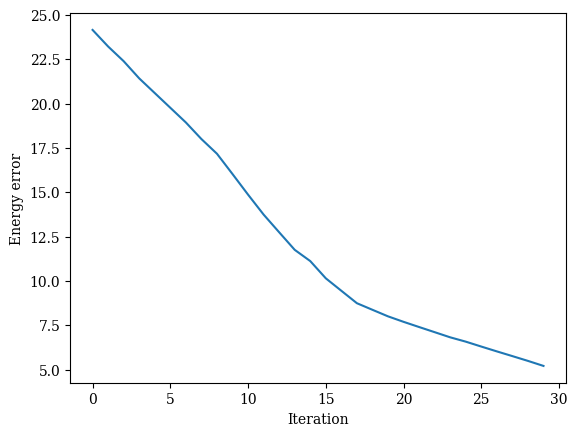

In [8]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [9]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Carry out SQD.

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state")

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [21]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 4, 'rx': 2, 'barrier': 2, 'u2': 1, 'rz': 1, 'h': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 8, 'rx': 4, 'h': 3, 'barrier': 3, 'rz': 2, 'u2': 1})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'x': 15, 'cx': 12, 'rx': 6, 'h': 5, 'barrier': 4, 'rz': 3, 'u2': 1})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 16, 'x': 15, 'rx': 8, 'h': 7, 'barrier': 5, 'rz': 4, 'u2': 1})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 20, 'x': 15, 'rx': 10, 'h': 9, 'barrier': 6, 'rz': 5, 'u2': 1})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 24, 'x': 15, 'rx': 12, 'h': 11, 'barrier': 7, 'rz': 6, 'u2': 1})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 32, 'cx': 28, 'x': 15, 'rx': 14, 'h': 13, '

In [28]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

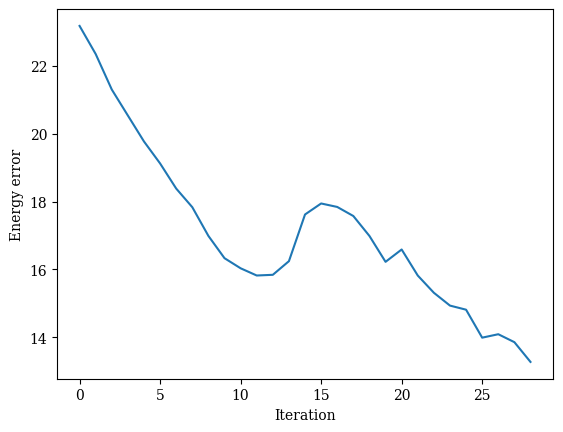

In [29]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [32]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

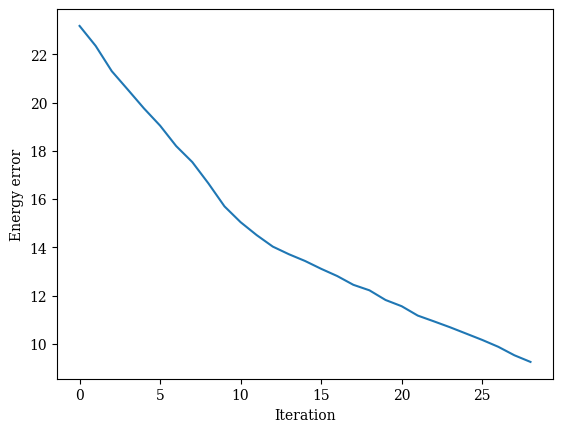

In [33]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

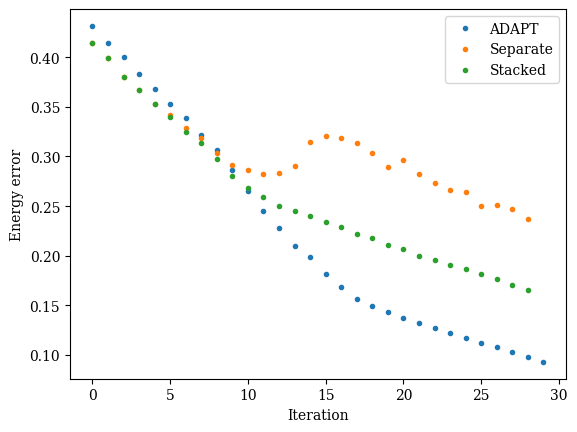

In [34]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()